# This notebook will build the model for predicting the price of properties. 
## 1. First basic model based on multiple linear regression.
### 1. import libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import sys
import pandas as pd
sys.path.insert(0, '../')
from src.clean_data import run_cleanup
from src.clean_data import split_df_on_type
from src.linear_model import model
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt


### 2. Read the csv-file and put it into a pandas DataFrame

print(df_house.head())
print(df_apt.head())

In [49]:
file_path = r'c:\Users\samve\OneDrive\0BeCode\repos\immo-data-processing\Data\Filtered_Data\house_details_v1.csv'
df = pd.read_csv(file_path, index_col='id', skip_blank_lines=True)

### 3. Clean data via clean_data.py:

In [4]:
drop_columns=[
            'Street', 'Housenumber', 'Box', 'City', 'Subtype', 'Location area', 'Region', 
            'District', 'Province', 'Type of sale', 'Garden', 'Kitchen type', 'EPC score', 'Latitude',
            'Longitude', 'Property url'
            ]
#trans_columns= ['Region', 'Province', 'Terrace', '']
df = run_cleanup(df, drop_columns)
df_house, df_apt = split_df_on_type(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19963 entries, 10683823 to 10664014
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Street             19963 non-null  object 
 1   Housenumber        19963 non-null  object 
 2   Box                19963 non-null  object 
 3   Floor              19963 non-null  float64
 4   City               19963 non-null  object 
 5   Postalcode         19963 non-null  float64
 6   Type               19963 non-null  object 
 7   Subtype            19963 non-null  object 
 8   Location area      19963 non-null  object 
 9   Region             19963 non-null  object 
 10  District           19963 non-null  object 
 11  Province           19963 non-null  object 
 12  Price              19963 non-null  float64
 13  Type of sale       19963 non-null  object 
 14  Construction year  19963 non-null  float64
 15  Total surface      19963 non-null  float64
 16  Habitable surface

#### 3.1 Check for features with too strong correlation (= more than 0.70)

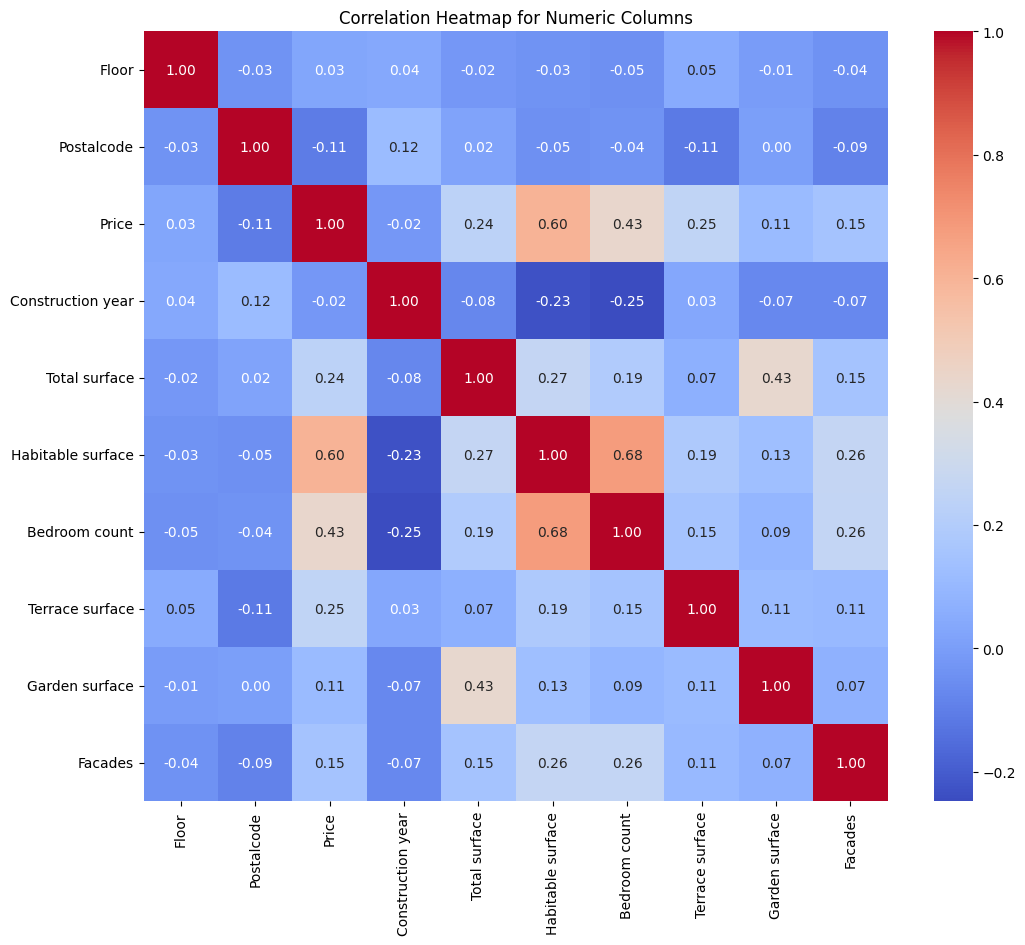

In [5]:
numeric_df = df.select_dtypes(include=[float, int])

# Compute the correlation matrix for the numeric columns
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Add a title to the heatmap
plt.title("Correlation Heatmap for Numeric Columns")

# Show the plot
plt.show()

### 4. First pipeline on the DataFrame:

In [6]:
df_columns = ['Habitable surface', 'Bedroom count', 'Postalcode', 'Terrace surface', 'Garden surface', 'Kitchen equiped', 'Construction year', 'Total surface', 'Garden surface', 'Facades']
X= df[df_columns].to_numpy()
y = df.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)

0.4167136740781614
107955115640.19704


Model running for house listings only

In [7]:
house_columns = ['Habitable surface', 'Bedroom count', 'Postalcode', 'Terrace surface', 'Garden surface', 'Kitchen equiped', 'Facades']
X = df_house[house_columns].to_numpy()
y = df_house.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)

0.4874577369562684
133202116367.02583


Model for apartment listings only

In [37]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equiped', 'Floor']
X = df_apt[apt_columns].to_numpy()
y = df_apt.Price.to_numpy().reshape(-1 , 1)
ones = np.ones((X.shape[0],1))
X = np.hstack((X, ones))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 123)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = lr()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_train, y_train)
MSE = mean_squared_error(y_true=y_test, y_pred=y_pred,)
print(score)
print(MSE)


0.3698425259531728
293392073005.94165


### 5. Try a non-linear model: XGboost

In [46]:
xgb_model = xgb.XGBRegressor(booster='gbtree', objective="reg:squarederror", random_state=123, n_estimators=2000, learning_rate=0.02, max_depth=6)
xgb_model.fit(X_train, y_train)
print(xgb_model.score(X_train, y_train))
print(xgb_model.score(X_test, y_test))
y_pred = xgb_model.predict(X_test)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R2 scores:", cv_scores)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
y_plot = xgb_model.predict(X).reshape(-1,1)
y = y.to_numpy()
print(df.shape)
print(X.shape)
print(y_plot.shape)
df1 = pd.DataFrame({'Price': y, 'Predicted': y_plot})
df1 = df1.sort_values(by='Price')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df1['Price'], y=df1['Predicted'], mode='markers', name='Predicted'))
fig.add_trace(go.Scatter(x=df1['Price'], y=df1['Price'], mode='lines', name='Actual'))
fig.update_layout(title='Regression Model Results', xaxis_title='Actual Price', yaxis_title='Predicted Value')
fig.show()

0.8504018767589294
0.424373016648689
Cross-validation R2 scores: [0.47059356 0.3671009  0.29262365 0.51865779 0.29618182]
Mean cross-validation R2 score: 0.38903154393560024
Standard deviation of cross-validation R2 scores: 0.09148970607812872


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:
print(df1.shape)
print(X.shape)
print(y_plot.shape)
print(y.shape)

NameError: name 'df1' is not defined

### 6. Try the complete pipeline, running the model function from linear_model.py
#### 1. Model 1 is LinearRegression (sklearn)

In [20]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equiped', 'Floor']
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score, fig = model(df_apt, apt_columns, model=1, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
fig.show()

ValueError: Per-column arrays must each be 1-dimensional

#### 2. Model 2 is XGboost

In [25]:
apt_columns = ['Habitable surface', 'Bedroom count', 'Terrace surface', 'Kitchen equiped', 'Floor']
regressor, score, mse, cv_scores, mean_cv_score, std_cv_score = model(df_apt, apt_columns, model=2, scaled=True )
print(f'The score for the model is: {score}\nThe MSE for this model is {mse}')
print("Cross-validation R2 scores:", cv_scores)
print("Mean cross-validation R2 score:", mean_cv_score)
print("Standard deviation of cross-validation R2 scores:", std_cv_score)
#fig.show()

The score for the model is: 0.424373016648689
The MSE for this model is 84901603214.77905
Cross-validation R2 scores: [0.47059356 0.3671009  0.29262365 0.51865779 0.29618182]
Mean cross-validation R2 score: 0.38903154393560024
Standard deviation of cross-validation R2 scores: 0.09148970607812872
